# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Importing other libraries

In [2]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
from collections import defaultdict
from datetime import datetime

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import keras

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler

/home/edi/anaconda3/envs/kerasgpu/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.
/home/edi/anaconda3/envs/kerasgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/edi/anaconda3/envs/kerasgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/edi/anaconda3/envs/kerasgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.

In [3]:
# create backup for each datasets
portfolio_bkup = portfolio.copy()
profile_bkup = profile.copy()
transcript_bkup = transcript.copy()

### Exploratory Data Analysis

#### Profile

In [4]:
profile.head(10)

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


In [5]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [6]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [7]:
profile[(profile.age == 118) & (profile.gender.isnull())].income.isnull().sum()

2175

In profile.json, missing age is coded as 118, gender not listed, and we also see that empty income coded as NaN. Let's see how many of these missing data are.

In [8]:
print("Number of missing age: ", len(profile[profile.age == 118]))
print("Number of missing gender: ", profile.gender.isnull().sum())
print("Number of NaN income: ", profile.income.isnull().sum())

Number of missing age:  2175
Number of missing gender:  2175
Number of NaN income:  2175


We see that the number of missing age is the same as number of NaN of income. Let's see if both of them are in the same row simultaneously.

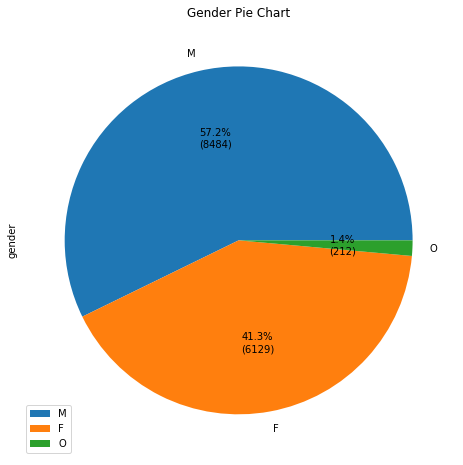

In [9]:
def autopct_label(pct, allvalues):
    """Recreate the value by multiplying the percentage by the total.
    
    Source=> https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    
    Args:
        pct (float) : percent for current piece of the pie.
        allvalues (Pandas Series): all values in the series.
    
    Returns:
        formatted string containing the % and the actual value.
    """
    absolute = int(np.round(pct/100. * np.sum(allvalues)))
    return f"{pct:.1f}%\n({absolute:d})"

profile.gender.value_counts().plot.pie(figsize=(8, 8),
                                       title='Gender Pie Chart',
                                       autopct=lambda pct: autopct_label(pct, profile.gender.value_counts()), 
                                       legend=True
                                      )

So, it is true that every profile.age column always correlated with NaN on profile.income and NaN on profile.gender.

Let's see the age distribution (with excluding 118)

<function matplotlib.pyplot.ylim(*args, **kwargs)>

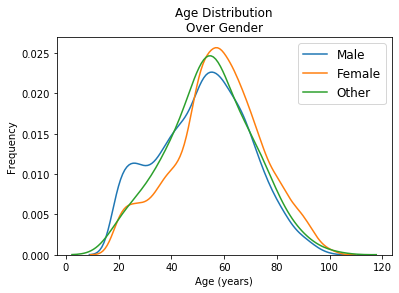

In [10]:
# Plot for male
age_data = profile[(profile.gender == 'M') & (profile.age < 118)].age
sns.distplot(age_data, hist = False, label = 'Male')

# Plot for female
age_data = profile[(profile.gender == 'F') & (profile.age < 118)].age
sns.distplot(age_data, hist = False, label = 'Female')

# Plot for other
age_data = profile[(profile.gender == 'O') & (profile.age < 118)].age
sns.distplot(age_data, hist = False, label = 'Other')

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Age Distribution\nOver Gender')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.ylim

Let's check the income distribution

No handles with labels found to put in legend.


Text(0, 0.5, 'Frequency')

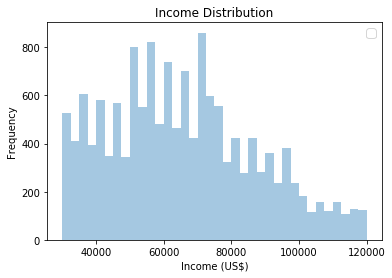

In [11]:
# Plot for income
sns.distplot(profile.income.dropna(), kde=False)

# Plot formatting
plt.legend(prop={'size': 12})
plt.title('Income Distribution')
plt.xlabel('Income (US$)')
plt.ylabel('Frequency')

Exploration on event transaction

#### Portfolio

In [12]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [13]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [14]:
portfolio.head(10)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


Seems like in channels there are more than one possible channel. In feature engineering we will one-hot-encoding this columns and also with offer_type since it is a categorical column so that we can feed this column to our model later.

#### Transcript

In [15]:
transcript.head(10)

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
5,389bc3fa690240e798340f5a15918d5c,offer received,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0
7,2eeac8d8feae4a8cad5a6af0499a211d,offer received,{'offer id': '3f207df678b143eea3cee63160fa8bed'},0
8,aa4862eba776480b8bb9c68455b8c2e1,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
9,31dda685af34476cad5bc968bdb01c53,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0


In [16]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [17]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


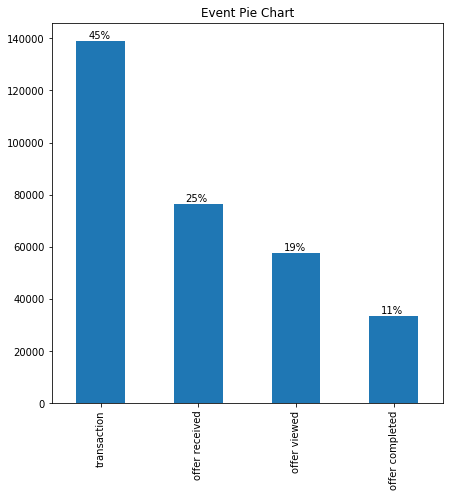

In [18]:
# Graph the event counts.
event_graph = transcript.event.value_counts().plot.bar(figsize=(7, 7), 
                                       title="Event Pie Chart")
for p in event_graph.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    event_graph.annotate('{:.0%}'.format(height/len(transcript.event)), (x + 0.12, y + height + 1000))

In [19]:
# Start changing
profile.rename(columns={'id': 'id_customer'}, inplace=True)
portfolio.rename(columns={'id': 'id_offer'}, inplace=True)
transcript.rename(columns={'person': 'id_customer'}, inplace=True)

In [20]:
# Check the result
profile.sample(5)

,gender,age,id_customer,became_member_on,income
3779,M,32,9f6907ec4e1846dc9266b0289bbce9fb,20171124,68000.0
16460,M,63,cae9515311754366aacb3044f0971484,20140609,47000.0
4428,F,86,84d9707ab6fe4f36a4b19a7a4a1c0cc8,20170202,92000.0
2003,F,68,4db0d031f3f44fb78be43bd2ffcccdad,20170905,76000.0
9347,M,18,73c5add7117c43b3b13a17cb05ae15ad,20160711,41000.0


In [21]:
portfolio.sample(5)

,reward,channels,difficulty,duration,offer_type,id_offer
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [22]:
transcript.sample(5)

,id_customer,event,value,time
23711,384c25983b6b40208362f8053b62378e,offer viewed,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},24
90862,2c2d6fcf6ba84ae78cd3b145107a486f,transaction,{'amount': 26.6},234
204998,4f7557d8237644248df653277ac6bce4,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},504
262571,fc8600d39af040a0a5bcf8e8311e4c29,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,582
267608,953d9e44fa3b46e788a540a26ec7eeec,offer viewed,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},588


### Feature Engineering

#### Portfolio  Feature Engineering
We will do:
1. One-Hot Encode channel column
2. One-Hot Encode offer_type
3. Drop channel column

In [23]:
def channel_labels(row, chan):
    """Convert channel list into separate columns,
        with 1 indicating in the list, and 0 otherwise.

    Args:
        row (Pandas dataframe row) = current row.
        chan (str) = channel name.
    """
    if chan in row['channels']:
        return 1
    else:
        return 0

In [24]:
# One-Hot Encode channel column
for channel in ["email", "mobile", "social", "web"]:
    portfolio[channel] = portfolio.apply(lambda row: channel_labels(row, channel), axis=1)
    
# Drop channels column
portfolio.drop(columns=['channels'], inplace=True)

portfolio.head()

,reward,difficulty,duration,offer_type,id_offer,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [25]:
# One-Hot Encode channel column
for offer in set(portfolio.offer_type.values):
    portfolio[f"offer_{offer}"] = portfolio.apply(lambda row: 1 if row["offer_type"] == offer else 0, axis=1)
    
# Drop channels column
portfolio.drop(columns=['offer_type'], inplace=True)

portfolio.head()

,reward,difficulty,duration,id_offer,email,mobile,social,web,offer_bogo,offer_informational,offer_discount
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,1,0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,0,1


In [26]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   reward               10 non-null     int64 
 1   difficulty           10 non-null     int64 
 2   duration             10 non-null     int64 
 3   id_offer             10 non-null     object
 4   email                10 non-null     int64 
 5   mobile               10 non-null     int64 
 6   social               10 non-null     int64 
 7   web                  10 non-null     int64 
 8   offer_bogo           10 non-null     int64 
 9   offer_informational  10 non-null     int64 
 10  offer_discount       10 non-null     int64 
dtypes: int64(10), object(1)
memory usage: 1008.0+ bytes


#### Profile Feature Engineering  
Changes:
1. Removing missing data (since the important possible category is missing: gender, income, and age)
2. One-Hot Encode gender
3. Determine the number of days of the customer membership
4. Drop unused column(s)

In [27]:
# Removing missing data

profile.dropna(inplace=True)

In [28]:
# Calculate the number of days customer has become member

profile["membership_total_days"] = profile.became_member_on.apply(lambda dt: (datetime.today() - datetime.strptime(str(dt), "%Y%m%d")).days)

# Store the year they became member on.
profile["membership_year"] = profile.became_member_on.apply(lambda dt: int(str(dt)[:4]))

In [29]:
# One-Hot encode gender.
for gender in set(profile.gender.values):
    profile[f"gender_{gender}"] = profile.apply(lambda row: 1 if row["gender"] == gender else 0, axis=1)

In [30]:
profile.drop(columns=['became_member_on', 'gender'], inplace=True, axis=0)

In [31]:
profile.head()

,age,id_customer,income,membership_total_days,membership_year,gender_O,gender_M,gender_F
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,995,2017,0,0,1
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1062,2017,0,0,1
5,68,e2127556f4f64592b11af22de27a7932,70000.0,710,2018,0,1,0
8,65,389bc3fa690240e798340f5a15918d5c,53000.0,786,2018,0,1,0
12,58,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,876,2017,0,1,0


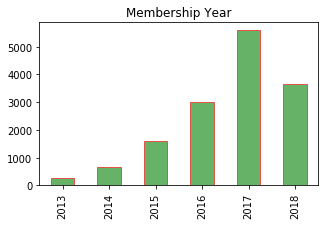

In [32]:
# Plot the number of memberships per year
membership_year_plot = profile.membership_year.value_counts().sort_index().plot(kind='bar', 
                                                                                color='g',
                                                                                edgecolor='r',
                                                                                alpha=0.60,
                                                                                figsize=(5, 3),
                                                                                title="Membership Year")

#### Transcript Feature Engineering  
Changes:
1. One-Hot Encode events
2. Take out offer id and make it as new column
3. Take out amount and make it as new column

In [33]:
# Get list of unique keys in the 'value' column dictionary
set_of_value_keys = {k for item in transcript.value.values for k in item.keys()}

print("Keys in 'values' column: ", set_of_value_keys)

Keys in 'values' column:  {'offer_id', 'reward', 'offer id', 'amount'}


In [34]:
def getOfferFromTranscript(d):
    """Given dictionary, get the offer from it (if present)."""
    if "offer id" in d:
        return d["offer id"]
    elif "offer_id" in d:
        return d["offer_id"]
    else:
        return np.nan

def getAmountFromTranscript(d):
    """Given dictionary, get the amount from it (if present)."""
    if "amount" in d:
        return d["amount"]
    else:
        return np.nan

We need to drop all transaction contain dropped customer when we did it to clean NA row

In [35]:
# Dropping all irrelevant to all id_customer in profile dataset
transcript = transcript[transcript.id_customer.isin(profile.id_customer.values)]

In [36]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 306532
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id_customer  272762 non-null  object
 1   event        272762 non-null  object
 2   value        272762 non-null  object
 3   time         272762 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 10.4+ MB


In [37]:
# One-Hot encode event in transcript dataset
for event in set(transcript.event.values):
    transcript[f"event_{event}"] = transcript.apply(lambda row: 1 if row["event"] == event else 0, axis=1)

In [38]:
# Get 'offer id' from value column dictionary and place in new column.
transcript["id_offer"] = transcript.value.apply(lambda x: getOfferFromTranscript(x))
    
# Get 'amount' from value column dictionary and place in new column.
transcript["trans_amt"] = transcript.value.apply(lambda x: getAmountFromTranscript(x))

In [39]:
# Drop unused columns
transcript.drop(columns=['event', 'value'], inplace=True, axis=1)

In [40]:
transcript.sample(10)

,id_customer,time,event_offer received,event_offer viewed,event_transaction,event_offer completed,id_offer,trans_amt
301272,058e689c3b554eaf868897c8cef80c82,690,0,0,1,0,NaN,1.80
139947,eff73dc9e26944cf8511b0742c579457,372,0,0,1,0,NaN,20.02
121648,948067179d174edc9a3893d926849575,336,1,0,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
17943,0b46f27233cf4f56b5ed434eccf401aa,6,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,NaN
182420,99bab80d141440859b6e09bf4fd9bda9,438,0,0,1,0,NaN,7.52
48606,c94f3d4f206647d18f2b3d80562af5cc,138,0,0,1,0,NaN,2.72
71708,f2aa77cb42534b00be0db65a811a9038,174,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN
269665,647970f8d1874fb69962663a59462745,594,0,0,1,0,NaN,25.98
38854,6cdaca9000bc4408921453abfafcc6d2,84,0,0,1,0,NaN,11.49
218167,a60dc180138d4278ae6c6eba2c364356,504,0,1,0,0,ae264e3637204a6fb9bb56bc8210ddfd,NaN


#### Merge three of the datasets  
We need to change column name so we can combine the datasets together. The changes are:
1. id => id_customer on profile
2. id => id_offer on portfolio
3. person => id_customer on transaction

In [41]:
# Merge datasets
combined = pd.merge(transcript, portfolio, how='left', on="id_offer")
combined = pd.merge(combined, profile, how='left', on="id_customer")

In [42]:
combined.sample(10)

,id_customer,time,event_offer received,event_offer viewed,event_transaction,event_offer completed,id_offer,trans_amt,reward,difficulty,...,offer_bogo,offer_informational,offer_discount,age,income,membership_total_days,membership_year,gender_O,gender_M,gender_F
80719,761e483441e942d6ad4a8c84a79605ce,234,0,0,1,0,NaN,26.98,NaN,NaN,...,NaN,NaN,NaN,49,81000.0,1254,2016,0,0,1
191154,8bdaca43bc4b4446ad8e86a82489fd23,504,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,...,0.0,0.0,1.0,23,65000.0,743,2018,0,0,1
154018,ac972e26b3824aa6b0fd04a1e8ea3173,420,0,0,1,0,NaN,0.08,NaN,NaN,...,NaN,NaN,NaN,44,67000.0,923,2017,0,1,0
206467,f119f4ea74b44e62b31e328d432695cd,534,0,0,1,0,NaN,1.68,NaN,NaN,...,NaN,NaN,NaN,63,61000.0,2004,2014,0,1,0
102195,7a88c1b8eb654e98b4595c642193d50d,336,1,0,0,0,3f207df678b143eea3cee63160fa8bed,NaN,0.0,0.0,...,0.0,1.0,0.0,33,51000.0,1080,2017,0,0,1
232410,4bffdccc6681472b9b61da924657de14,576,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,...,1.0,0.0,0.0,63,74000.0,741,2018,0,0,1
256491,398d2fec9c9f4d759c5565caf97d1f80,642,0,0,0,1,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,...,0.0,0.0,1.0,53,87000.0,1567,2015,0,1,0
92673,4acef5f30b3c468facf21c59294d4285,294,0,0,1,0,NaN,10.95,NaN,NaN,...,NaN,NaN,NaN,55,75000.0,1524,2016,0,0,1
97589,c997ff8618074ed9b5c1421ec762c4e7,324,0,0,1,0,NaN,19.42,NaN,NaN,...,NaN,NaN,NaN,52,73000.0,1348,2016,0,1,0
197389,9a3fdbdde97f48748fedea07119e148d,516,0,0,0,1,ae264e3637204a6fb9bb56bc8210ddfd,NaN,10.0,10.0,...,1.0,0.0,0.0,43,39000.0,844,2017,0,0,1


In [43]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_customer            272762 non-null  object 
 1   time                   272762 non-null  int64  
 2   event_offer received   272762 non-null  int64  
 3   event_offer viewed     272762 non-null  int64  
 4   event_transaction      272762 non-null  int64  
 5   event_offer completed  272762 non-null  int64  
 6   id_offer               148805 non-null  object 
 7   trans_amt              123957 non-null  float64
 8   reward                 148805 non-null  float64
 9   difficulty             148805 non-null  float64
 10  duration               148805 non-null  float64
 11  email                  148805 non-null  float64
 12  mobile                 148805 non-null  float64
 13  social                 148805 non-null  float64
 14  web                    148805 non-nu

We see that in some column there is NaN value. So, we will fill this value based on:
1. id_offer => '-' since this category won't be used in model because of it is not a number
2. trans_amt => 0
3. difficulty => mean
4. duration => mean
5. reward =>  0
6. email => 0
7. mobile => 0
8. social => 0
9. web => 0
10. offer_discount => 0
11. offer_bogo => 0
12. offer_informational => 0

In [44]:
# Fill NaN stage-1
for column in ['trans_amt', 'reward', 'email', 'mobile', 'social', 'web', 'offer_discount', 'offer_bogo', 'offer_informational']:
    combined[column].fillna(0, inplace=True)

In [45]:
# Fill NaN stage-2
for column in ['difficulty', 'duration']:
    combined[column].fillna(combined[column].mean(), inplace=True)

In [46]:
# Fill NaN stage-3
combined['id_offer'].fillna('-', inplace=True)

In [47]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 272761
Data columns (total 25 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id_customer            272762 non-null  object 
 1   time                   272762 non-null  int64  
 2   event_offer received   272762 non-null  int64  
 3   event_offer viewed     272762 non-null  int64  
 4   event_transaction      272762 non-null  int64  
 5   event_offer completed  272762 non-null  int64  
 6   id_offer               272762 non-null  object 
 7   trans_amt              272762 non-null  float64
 8   reward                 272762 non-null  float64
 9   difficulty             272762 non-null  float64
 10  duration               272762 non-null  float64
 11  email                  272762 non-null  float64
 12  mobile                 272762 non-null  float64
 13  social                 272762 non-null  float64
 14  web                    272762 non-nu

In [48]:
# Rename some columns
combined.rename(columns={'event_offer received': 'event_offer_received', 'event_offer completed': 'event_offer_completed', 'event_offer viewed': 'event_offer_viewed'}, inplace=True)

In [49]:
combined.sample(10)

,id_customer,time,event_offer_received,event_offer_viewed,event_transaction,event_offer_completed,id_offer,trans_amt,reward,difficulty,...,offer_bogo,offer_informational,offer_discount,age,income,membership_total_days,membership_year,gender_O,gender_M,gender_F
189033,672ea74b67fc44dc8ffa6ebe935c5c64,504,1,0,0,0,2298d6c36e964ae4a3e7e9706d1fb8c2,0.00,3.0,7.000000,...,0.0,0.0,1.0,47,70000.0,1481,2016,0,0,1
253136,ef19f741b64545cd9bcfa2d537a7b968,630,0,0,1,0,-,6.98,0.0,7.890561,...,0.0,0.0,0.0,27,34000.0,868,2017,0,1,0
66209,f6251250f1044d7cb66270f8aa380d9a,180,0,0,1,0,-,21.60,0.0,7.890561,...,0.0,0.0,0.0,73,52000.0,706,2018,1,0,0
267010,28d6452ecc534860b70ab53d92dd1acf,684,0,0,1,0,-,16.74,0.0,7.890561,...,0.0,0.0,0.0,52,84000.0,1571,2015,0,0,1
113300,7f7ec04e9cae4375a5b2c9bc2fc25232,342,0,0,1,0,-,7.13,0.0,7.890561,...,0.0,0.0,0.0,69,73000.0,933,2017,0,1,0
46890,ab5e1ca0319147708e1fd2647125ba20,162,0,0,1,0,-,3.27,0.0,7.890561,...,0.0,0.0,0.0,41,65000.0,1774,2015,0,1,0
146406,4828935e6d8c449195b5cf5692ebba0d,408,0,0,1,0,-,20.38,0.0,7.890561,...,0.0,0.0,0.0,60,91000.0,1478,2016,0,1,0
140066,ea9a6c23a601434c92072dfbc6483d57,408,1,0,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,5.0,5.000000,...,1.0,0.0,0.0,64,72000.0,1610,2015,0,1,0
27987,2cef524a7be341e0b51ff1a3b1228a78,54,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,5.0,5.000000,...,1.0,0.0,0.0,88,95000.0,1676,2015,0,0,1
122961,e820e95254a24e9abe9704555f8bbee2,366,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.00,5.0,5.000000,...,1.0,0.0,0.0,52,56000.0,638,2018,0,0,1


#### Split Data
Split into Training, Test, and Validation into 60%, 20%, and 20% of the data.  Our target will be event_offer_completed and the features are the rest of numerical column of combined dataframe

In [50]:
label = combined.event_offer_completed
features = combined.drop(columns=['id_customer', 'id_offer'])

In [51]:
# Perform splitting for testing
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.3, random_state=42)

# # Perform splitting for validation and test
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=21)

### Build the models
1. Logistic Regression
2. Support Vector Machines
3. Neural Networks (Keras)

#### Logistic Regression

In [52]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

In [53]:
from sklearn.model_selection import GridSearchCV

# Model declaration
logreg = LogisticRegression()

# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create grid search using 5-fold cross validation
clf = GridSearchCV(logreg, hyperparameters, n_jobs=-1, cv=5, verbose=0, scoring='f1')

In [54]:
def scoring(y_pred, y_test):
    print("Accuracy: ", accuracy_score(y_pred, y_test))
    print("Precision: ", precision_score(y_pred, y_test))
    print("Recall: ", recall_score(y_pred, y_test))
    print("AUC: ", roc_auc_score(y_pred, y_test))
    print("F1 Score ", f1_score(y_pred, y_test))

In [55]:
best_logreg_model = clf.fit(X_train, y_train)

/home/edi/.local/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [56]:
y_pred = best_logreg_model.predict(X_test)

In [57]:
confusion_matrix(y_test, y_pred)

array([[71873,   295],
       [ 9361,   300]])

In [58]:
scoring(y_pred, y_test)

Accuracy:  0.8819978247320632
Precision:  0.03105268605734396
Recall:  0.5042016806722689
AUC:  0.6944833402745838
F1 Score  0.05850234009360375


In [59]:
# View best hyperparameters
print('Best Penalty:', best_logreg_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_logreg_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 7.742636826811269


#### TPOTClassifier
Using the TPOTClassifier to automate Machine Learning Pipeline

In [73]:
!pip install tpot

     |████████████████████████████████| 81kB 50kB/s eta 0:00:01
     |████████████████████████████████| 163kB 15kB/s eta 0:00:01
  Created wheel for stopit: filename=stopit-1.1.2-cp37-none-any.whl size=11958 sha256=0c55c83419086db77deb9d63e9fd6d468be42754fcb8b2a084fd6faa3475a584
  Stored in directory: /home/edi/.cache/pip/wheels/3c/85/2b/2580190404636bfc63e8de3dff629c03bb795021e1983a6cc7
Successfully built stopit


In [75]:
# Import TPOTClassifier and roc_auc_score
from tpot import TPOTClassifier
from sklearn.metrics import roc_auc_score

In [77]:
# Instantiate TPOTClassifier
tpot = TPOTClassifier(
    generations=5,
    population_size=20,
    verbosity=2,
    scoring='f1',
    random_state=42,
    disable_update_check=True,
    config_dict=None
)
tpot.fit(X_train, y_train)

Generation 1 - Current best internal CV score: 1.0
Generation 2 - Current best internal CV score: 1.0
Generation 3 - Current best internal CV score: 1.0
Generation 4 - Current best internal CV score: 1.0
Generation 5 - Current best internal CV score: 1.0

Best pipeline: DecisionTreeClassifier(input_matrix, criterion=entropy, max_depth=4, min_samples_leaf=3, min_samples_split=18)


TPOTClassifier(config_dict=None, crossover_rate=0.1, cv=5,
               disable_update_check=True, early_stop=None, generations=5,
               max_eval_time_mins=5, max_time_mins=None, memory=None,
               mutation_rate=0.9, n_jobs=1, offspring_size=None,
               periodic_checkpoint_folder=None, population_size=20,
               random_state=42, scoring='f1', subsample=1.0, template=None,
               use_dask=False, verbosity=2, warm_start=False)

In [79]:
# AUC score for tpot model
tpot_auc_score = roc_auc_score(y_test, tpot.predict_proba(X_test)[:, 1])
print(f'\nAUC score: {tpot_auc_score:.4f}')

# Print best pipeline steps
print('\nBest pipeline steps:', end='\n')
for idx, (name, transform) in enumerate(tpot.fitted_pipeline_.steps, start=1):
    # Print idx and transform
    print(f'{idx}. {transform}')


AUC score: 1.0000

Best pipeline steps:
1. DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=18,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')


In [80]:
y_pred = tpot.predict(X_test)

In [81]:
accuracy_score(y_pred, y_test)

1.0

In [82]:
confusion_matrix(y_test, y_pred)

array([[72168,     0],
       [    0,  9661]])

So, we actually get the best model which is DecisionTreeClassifier with outstanding result of perfect accuracy, perfect precision, and perfect recall.

#### Support Vector Machines

In [83]:
from sklearn.svm import LinearSVC, SVC

In [84]:
svm = SVC()
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [85]:
y_pred = svm.predict(X_test)

In [86]:
confusion_matrix(y_test, y_pred)

array([[72168,     0],
       [ 9661,     0]])

In [88]:
print('Accuracy Score: ', accuracy_score(y_pred, y_test))
print('Precision Score: ', precision_score(y_pred, y_test))
print('Recall Score: ', recall_score(y_pred, y_test))

Accuracy Score:  0.8819367217001307
Precision Score:  0.0
Recall Score:  0.0


/home/edi/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [90]:
# Model declaration
svm = LinearSVC()

# Create regularization hyperparameter space
C = np.logspace(-1, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
svm_clf = GridSearchCV(svm, hyperparameters, n_jobs=-1, cv=5, verbose=0, scoring='accuracy')

In [91]:
best_svm_model = svm_clf.fit(X_train, y_train)

/home/edi/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [92]:
y_pred = best_svm_model.predict(X_test)

In [94]:
print('Accuracy Score: ', accuracy_score(y_pred, y_test))
print('Precision Score: ', precision_score(y_pred, y_test))
print('Recall Score: ', recall_score(y_pred, y_test))

Accuracy Score:  0.8819367217001307
Precision Score:  0.0
Recall Score:  0.0


/home/edi/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
# Model declaration
svm = LinearSVC()

# Create regularization hyperparameter space
C = np.logspace(-1, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C)

# Create grid search using 5-fold cross validation
svm_clf = GridSearchCV(svm, hyperparameters, n_jobs=-1, cv=5, verbose=0, scoring='f1_micro')

In [96]:
best_svm_model = svm_clf.fit(X_train, y_train)

/home/edi/.local/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [97]:
y_pred = best_svm_model.predict(X_test)

In [98]:
print('Accuracy Score: ', accuracy_score(y_pred, y_test))
print('Precision Score: ', precision_score(y_pred, y_test))
print('Recall Score: ', recall_score(y_pred, y_test))

Accuracy Score:  0.8819367217001307
Precision Score:  0.0
Recall Score:  0.0


/home/edi/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Neural Network

In [106]:
from keras.layers import Input, Dense, Dropout, Flatten
from keras.models import Model

In [107]:
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
import time

In [128]:
type(X_train.shape[1])

int

In [132]:
input_layer = Input(shape=(23,))
dense_1 = Dense(32, activation='relu')(input_layer)
dropout_1 = Dropout(0.1)(dense_1)
dense_2 = Dense(32, activation='relu')(dropout_1)
dropout_2 = Dropout(0.1)(dense_2)
output_layer = Dense(1, activation='sigmoid')(dropout_2)

model = Model(inputs=[input_layer], outputs=[output_layer])
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 23)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                768       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 1,857
Traina

In [173]:
model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])


result = model.fit(X_train, y_train, batch_size=64, epochs=8, verbose=1, validation_data=(X_test, y_test))

Train on 190933 samples, validate on 81829 samples
Epoch 1/8
190933/190933 [==============================] - 7s 37us/step - loss: 1.9233 - acc: 0.8807 - val_loss: 1.9030 - val_acc: 0.8819
Epoch 2/8
190933/190933 [==============================] - 7s 35us/step - loss: 1.9233 - acc: 0.8807 - val_loss: 1.9030 - val_acc: 0.8819
Epoch 3/8
190933/190933 [==============================] - 7s 35us/step - loss: 1.9233 - acc: 0.8807 - val_loss: 1.9030 - val_acc: 0.8819
Epoch 4/8
190933/190933 [==============================] - 7s 34us/step - loss: 1.9233 - acc: 0.8807 - val_loss: 1.9030 - val_acc: 0.8819
Epoch 5/8
190933/190933 [==============================] - 7s 34us/step - loss: 1.9233 - acc: 0.8807 - val_loss: 1.9030 - val_acc: 0.8819
Epoch 6/8
190933/190933 [==============================] - 7s 34us/step - loss: 1.9233 - acc: 0.8807 - val_loss: 1.9030 - val_acc: 0.8819
Epoch 7/8
190933/190933 [==============================] - 7s 34us/step - loss: 1.9233 - acc: 0.8807 - val_loss: 1.9030 -

In [175]:
y_pred = model.predict(X_test)

In [176]:
confusion_matrix(y_test, y_pred)

array([[72168,     0],
       [ 9661,     0]])

In [177]:
print('Accuracy Score: ', accuracy_score(y_pred, y_test))
print('Precision Score: ', precision_score(y_pred, y_test))
print('Recall Score: ', recall_score(y_pred, y_test))

Accuracy Score:  0.8819367217001307
Precision Score:  0.0
Recall Score:  0.0


/home/edi/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Conclusion
## Reflection
After I finished this projects, seems like this projects is pretty hard to handle for my current skill level. My SVC and Neural Network model is not working well eventhough this capstone project is mainly as my experiment to use my skill. I need to improve my neural network skill (which is on its way) and deepen my feature engineering and hyperparameter tuning skill.
## Improvement
From my reflection explained above, I need to change the way I do feature engineering. This happen especially on how I use missing values. Another thing to improve is how I implement my SVM and Neural Network model. I will implement all of this right after I finish my deeper machine learning and deep learning courses on Udacity.